# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

/Users/david/local/WORK/soil-prediction/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Complete pipeline

## Data Preprocessing

In [3]:
# Data Loading & Preprocessing
df = pd.read_csv('./data/model_data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Define input and output features (excluding 'date' for model training)
input_features = [
    'precipitation + irrigation (mm)',
    'potential evapotranspiration (mm)',
    # 'year',
    # 'month',
    # 'day',
    # 'day_of_week',
    # 'day_of_year',
    'precip_pet_diff',
    'precip_7d_avg',
    'pet_7d_avg',
    # 'precip_7d_sum',
    # 'pet_7d_sum'
]

output_features = [
    'depth 10cm',
    'depth 30cm',
    'depth 60cm',
    'depth 90cm',
    'actual evapotranspiration (mm)',
    'groundwater recharge (mm)'
]

# Convert DataFrame columns to NumPy arrays
X = df[input_features].values
y = df[output_features].values

# Scale the features for better LSTM performance
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Create Sequences for LSTM Input
def create_sequences(X, y, lookback=7):
    """
    Create sequences of length 'lookback' from the time series data.
    For each sample, the input is the previous 'lookback' days
    and the output is the target for the day following the sequence.
    """
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

lookback = 7  # Use the past 7 days to predict the next day
X_seq, y_seq = create_sequences(X_scaled, y_scaled, lookback)

## Split

In [4]:
# Train/Test Split (Time-based)
split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

## Model Configuration

In [5]:

# Build the LSTM Model
model = Sequential()
# First LSTM layer; returns sequences for the next LSTM layer
model.add(LSTM(50, activation='relu', return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
# Second LSTM layer; does not return sequences
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
# Dense layer for multi-output regression (6 target variables)
model.add(Dense(len(output_features)))

# Set a custom learning rate
learning_rate = 0.00005  # Try values like 0.0001, 0.0005, 0.005, 0.01, etc.
optimizer = Adam(learning_rate=learning_rate)

# Compile model with custom learning rate
model.compile(optimizer=optimizer, loss='mse')
model.summary()

/Users/david/local/WORK/soil-prediction/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 50)          │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,706 (123.85 KB)

 Trainable params: 31,706 (123.85 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [6]:
# Train the Model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, 
                    validation_split=0.1, verbose=1)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9848 - val_loss: 1.8703
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9742 - val_loss: 1.8625
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9353 - val_loss: 1.8564
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9645 - val_loss: 1.8504
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9289 - val_loss: 1.8447
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9500 - val_loss: 1.8379
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9744 - val_loss: 1.8326
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9514 - val_loss: 1.8270
Epoch 9/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8797 - val_loss: 1.8251
Epoch 10/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9131 - val_loss: 1.8193
Epoch 11/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8604 - val_loss: 1.8132
Epoch 12/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9124 - val_l

## Evaluation

In [7]:
# Predict and Evaluate
# Predict on the test set
y_pred_scaled = model.predict(X_test)
# Inverse transform to get predictions in the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# Evaluate using Mean Squared Error (MSE)
mse = mean_squared_error(y_test_inv, y_pred)
print("Test MSE:", mse) 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Test MSE: 1.4737871825198383


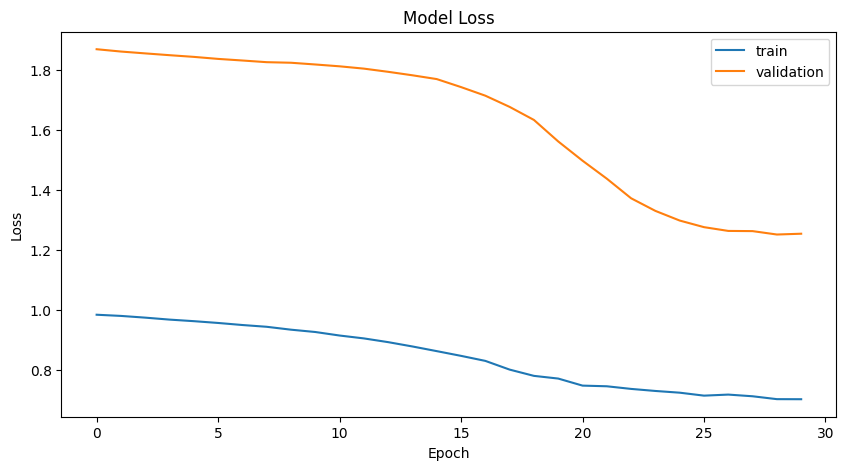

In [8]:
# plot training history
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

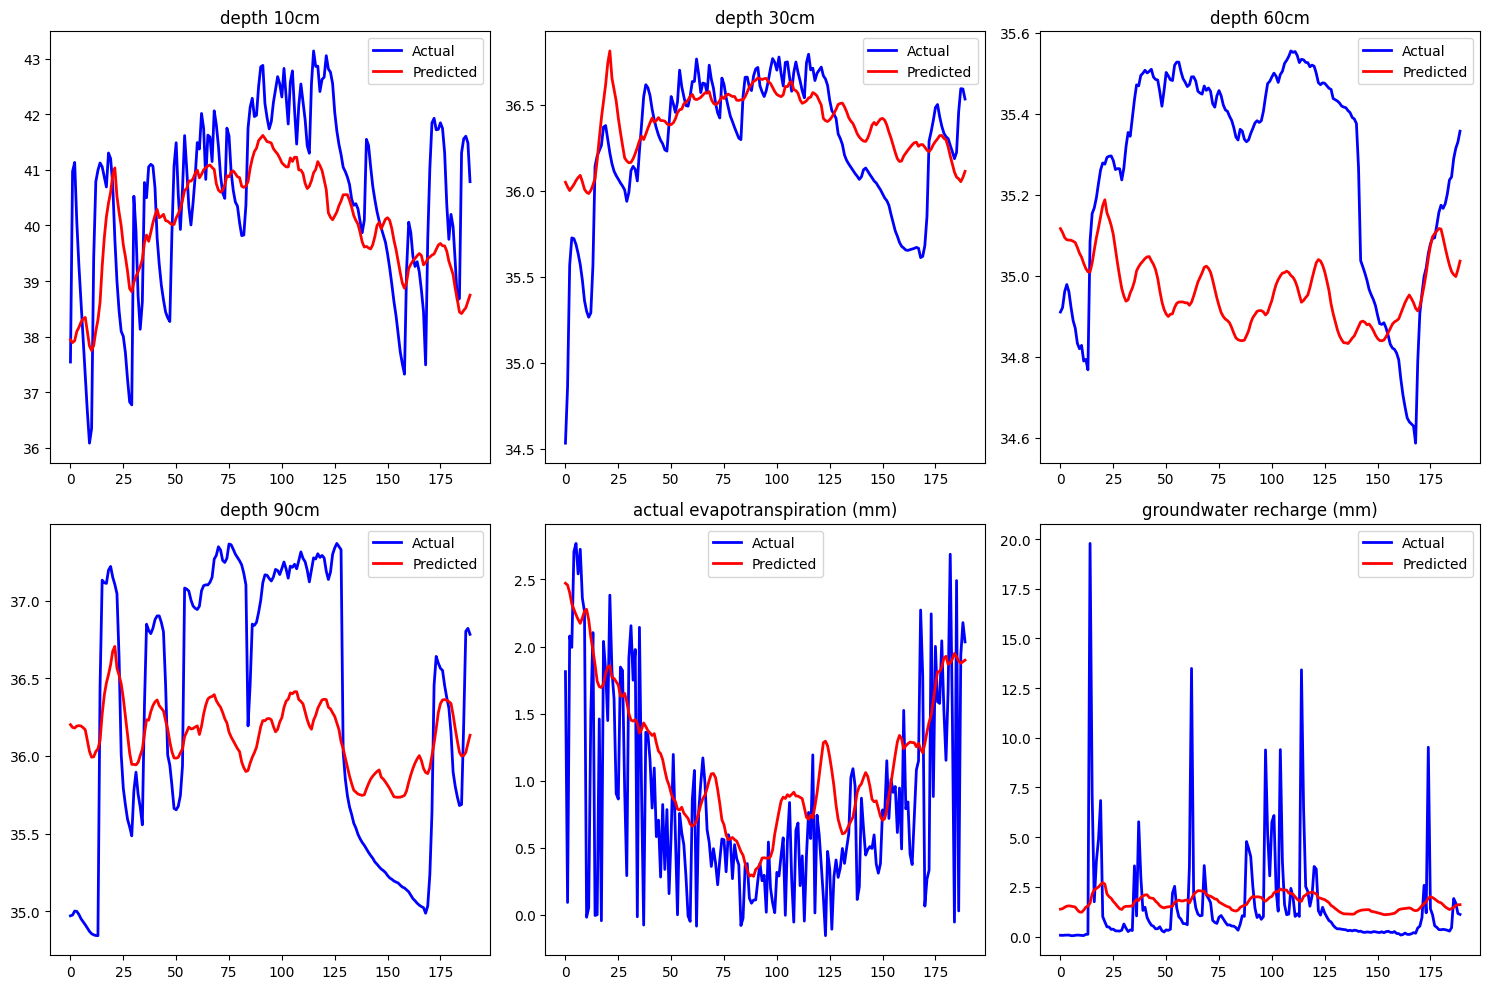

In [9]:
# Plot the actual vs. predicted values for each target variable
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(y_test_inv[:, i], label='Actual', color='blue', linewidth=2)
    ax.plot(y_pred[:, i], label='Predicted', color='red', linewidth=2)
    ax.set_title(output_features[i])
    ax.legend()

plt.tight_layout()
plt.show()


In [10]:
# Calculate MSE for each target variable
mse_per_target = {}
for i, feature in enumerate(output_features):
    mse_per_target[feature] = mean_squared_error(y_test_inv[:, i], y_pred[:, i])
    # print(f"{feature}: {mse_per_target[feature]:.2f}")


print("Mean Squared Error for each target variable:")
for feature, mse_val in mse_per_target.items():
    print(f"   {feature}: {mse_val:.2f}")
print("\nOverall Mean Squared Error:", mse)



Mean Squared Error for each target variable:
   depth 10cm: 1.74
   depth 30cm: 0.10
   depth 60cm: 0.17
   depth 90cm: 0.61
   actual evapotranspiration (mm): 0.44
   groundwater recharge (mm): 5.79

Overall Mean Squared Error: 1.4737871825198383
